In [1]:
import SimpleITK as sitk
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from rabies.visualization import otsu_scaling, plot_3d
import nilearn.plotting
from rabies.utils import recover_3D
from rabies.analysis_pkg.diagnosis_pkg.analysis_QC import masked_plot, percent_threshold
import pandas as pd
import matplotlib.cm as cm


plt.rcParams.update({
    "lines.color": "black",
    "patch.edgecolor": "black",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})


template_file='/home/gabriel/.local/share/rabies/EPI_template.nii.gz'
scaled = otsu_scaling(template_file)


230810-15:57:11,959 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.0


/home/gabriel/miniconda3/envs/rabies_analysis_repro/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Create dictionary with QC measures for each dataset, analysis and CR strategy

In [2]:
FC_list=['DR0','seed_FC1','DR1','seed_FC0']

CR_list=['raw', 'FD', 'mot6_FD', 'mot6_FD_no_QC', 'mot6_FD_standard', 'mot6_FD_DVARS', 'mot24_FD', 
         'mot6_FD_WM_CSF', 'mot6_FD_aCompCor5', 'mot6_FD_global', 'mot6_FD_highpass', 'mot6_FD_AROMA', 'optimized']

datasets = ['7_Cryo_aw_f','7_Cryo_med_f1', '7_Cryo_med_f2','7_Cryo_med_f3',
'7_Cryo_mediso_v','7_RT_halo_v', '7_RT_iso_f','7_RT_med_f','47_RT_iso_f','94_Cryo_iso_f','94_Cryo_med_f','94_Cryo_mediso_v',
'94_RT_iso_v','94_RT_mediso_f1','94_RT_mediso_f2','117_Cryo_iso_f','117_Cryo_mediso_v',
'grandjean_aw','grandjean_mediso']

# predominant scan category
dataset_categories={}
dataset_categories['7_Cryo_aw_f']='Mixed'
dataset_categories['7_Cryo_med_f1']='absent'
dataset_categories['7_Cryo_med_f2']='absent'
dataset_categories['7_Cryo_med_f3']='Mixed'
dataset_categories['7_Cryo_mediso_v']='specific'
dataset_categories['7_RT_halo_v']='Mixed'
dataset_categories['7_RT_iso_f']='absent'
dataset_categories['7_RT_med_f']='absent'
dataset_categories['47_RT_iso_f']='Mixed'
dataset_categories['94_Cryo_iso_f']='Spurious'
dataset_categories['94_Cryo_med_f']='Mixed'
dataset_categories['94_Cryo_mediso_v']='Mixed'
dataset_categories['94_RT_iso_v']='Mixed'
dataset_categories['94_RT_mediso_f1']='absent'
dataset_categories['94_RT_mediso_f2']='Mixed'
dataset_categories['117_Cryo_iso_f']='Spurious'
dataset_categories['117_Cryo_mediso_v']='specific'
dataset_categories['grandjean_aw']='Mixed'
dataset_categories['grandjean_mediso']='specific'


optimized_CR={}
optimized_CR['7_Cryo_aw_f']='optimized_CR4'
optimized_CR['7_Cryo_med_f1']='optimized_CR2'
optimized_CR['7_Cryo_med_f2']='optimized_CR3'
optimized_CR['7_Cryo_med_f3']='optimized_CR3'
optimized_CR['7_Cryo_mediso_v']='mot6_FD_highpass'
optimized_CR['7_RT_halo_v']='optimized_CR3'
optimized_CR['7_RT_iso_f']='mot6_FD'
optimized_CR['7_RT_med_f']='optimized_CR2'
optimized_CR['47_RT_iso_f']='mot6_FD_standard'
optimized_CR['94_Cryo_iso_f']='optimized_CR7'
optimized_CR['94_Cryo_med_f']='optimized_CR3'
optimized_CR['94_Cryo_mediso_v']='optimized_CR4'
optimized_CR['94_RT_iso_v']='optimized_CR4'
optimized_CR['94_RT_mediso_f1']='mot6_FD'
optimized_CR['94_RT_mediso_f2']='optimized_CR7'
optimized_CR['117_Cryo_iso_f']='optimized_CR6'
optimized_CR['117_Cryo_mediso_v']='mot6_FD'
optimized_CR['grandjean_aw']='optimized_CR3'
optimized_CR['grandjean_mediso']='mot6_FD_AROMA'


# load all data into a dictionary
FC_stats={}
for CR in CR_list:
    print(CR)
    FC_stats[CR]={}
    for FC in FC_list:
        FC_stats[CR][FC]={}
        for dataset in datasets:
            if CR=='optimized':
                CR_read=optimized_CR[dataset]
            else:
                CR_read=CR
            FC_stats[CR][FC][dataset]={}
            FC_stats[CR][FC][dataset]['CR_read'] = CR_read
            try:
                if dataset=='grandjean_aw':
                    df_dist = pd.read_csv(f'diagnosis_outputs/{CR_read}/bids_grandjean_rest_awk_bold_only_subset_awake/analysis_QC/analysis_QC/sample_distributions/{FC}_outlier_detection.csv')
                elif dataset=='grandjean_mediso':
                    df_dist = pd.read_csv(f'diagnosis_outputs/{CR_read}/bids_grandjean_rest_awk_bold_only_subset_mediso/analysis_QC/analysis_QC/sample_distributions/{FC}_outlier_detection.csv')
                else:
                    df_dist = pd.read_csv(f'diagnosis_outputs/{CR_read}/{dataset}/analysis_QC/analysis_QC/sample_distributions/{FC}_outlier_detection.csv')
            except:
                print(f"{CR} is missing in {dataset}")
                FC_stats[CR][FC][dataset]['criterion']=0
                continue
                
            num_scans = df_dist['QC inclusion?'].sum()
            FC_stats[CR][FC][dataset]['num_scans'] = num_scans
            FC_stats[CR][FC][dataset]['Dice'] = df_dist['Dice overlap']
            FC_stats[CR][FC][dataset]['Conf'] = df_dist['DR confound corr.']
            
            if num_scans<8: # group stats are only considered with at least 8 scans
                continue
                
            if dataset=='grandjean_aw':
                df = pd.read_csv(f'diagnosis_outputs/{CR_read}/bids_grandjean_rest_awk_bold_only_subset_awake/analysis_QC/analysis_QC/parametric_stats/{FC}_QC_stats.csv')
            elif dataset=='grandjean_mediso':
                df = pd.read_csv(f'diagnosis_outputs/{CR_read}/bids_grandjean_rest_awk_bold_only_subset_mediso/analysis_QC/analysis_QC/parametric_stats/{FC}_QC_stats.csv')
            else:
                df = pd.read_csv(f'diagnosis_outputs/{CR_read}/{dataset}/analysis_QC/analysis_QC/parametric_stats/{FC}_QC_stats.csv')
            for column in ['Overlap: Prior - Group average', 'Overlap: Prior - Cross-scan variability', 'Avg.: CRsd', 'Avg.: Mean FD']:
                FC_stats[CR][FC][dataset][column] = df[column].values[0]
            try:
                for column in ['Avg.: tDOF']:
                    FC_stats[CR][FC][dataset][column] = df[column].values[0]
            except: # some may have no tDOF difference between scans
                for column in ['Avg.: tDOF']:
                    FC_stats[CR][FC][dataset][column] = 0
                        
            

raw
FD
mot6_FD
mot6_FD_no_QC
mot6_FD_standard
mot6_FD_DVARS
mot24_FD
mot6_FD_WM_CSF
mot6_FD_aCompCor5
mot6_FD_global
mot6_FD_highpass
mot6_FD_AROMA
optimized


## Inspect scan-level Dice/Conf

In [3]:

FC_list=['DR0','DR1','seed_FC1','seed_FC0']
FC_list=['DR0']

for CR_type in ['initial', 'optimized']:
    for FC,dice_threshold in zip(FC_list, [0.4,0.3,0.4,0.3]):

        if CR_type=='initial':
            CR='mot6_FD'
        else:
            CR='optimized'

        QC_dict={}
        QC_dict['conf']={}
        QC_dict['dice']={}
        QC_dict['dice']['specific']=[]
        QC_dict['dice']['absent']=[]
        QC_dict['dice']['Mixed']=[]
        QC_dict['dice']['Spurious']=[]
        QC_dict['conf']['specific']=[]
        QC_dict['conf']['absent']=[]
        QC_dict['conf']['Mixed']=[]
        QC_dict['conf']['Spurious']=[]

        conf_df_list=[]
        dice_df_list=[]
        for dataset in datasets:
            for dice,conf in zip(FC_stats[CR][FC][dataset]['Dice'],FC_stats[CR][FC][dataset]['Conf']):
                dice_df_list.append(dice)
                conf_df_list.append(conf)
        dice_pass = np.array(dice_df_list)>dice_threshold
        conf_pass = np.array(conf_df_list)<0.25
        num_pass = (dice_pass*conf_pass).sum()
        print(f'{FC} - {CR_type}: Dice {dice_pass.sum()}/{len(dice_df_list)}')
        print(f'{FC} - {CR_type}: Conf {conf_pass.sum()}/{len(dice_df_list)}')
        print(f'{FC} - {CR_type}: Both {num_pass}/{len(dice_df_list)}')


DR0 - initial: Dice 223/353
DR0 - initial: Conf 295/353
DR0 - initial: Both 201/353
DR0 - optimized: Dice 216/347
DR0 - optimized: Conf 331/347
DR0 - optimized: Both 211/347


In [4]:
from scipy import stats

def plot_density(v, bounds, ax, color, axis='x'):
    xs = np.linspace(bounds[0],bounds[1],200)
    density = stats.gaussian_kde(v)
    if axis=='x':
        ax.plot(xs,density(xs), color=color)
        # here we append a 0 at each extreme to make sure the filling goes down to the axis at 0
        ax.fill_between(np.append(np.append(xs.min(),xs),xs.max()), 
                        np.append(np.append(0,density(xs)),0),
                        alpha=0.3, color=color)
        ax.set_ylim([0,set_bounds(density(xs),edge=1.2)[1]])
        ax.set_xlim(bounds)
    elif axis=='y':
        ax.plot(density(xs), xs, color=color)
        # here we append a 0 at each extreme to make sure the filling goes down to the axis at 0
        ax.fill_between(np.append(np.append(0,density(xs)),0),
                        np.append(np.append(xs.min(),xs),xs.max()), 
                        alpha=0.3, color=color)
        ax.set_xlim([0,set_bounds(density(xs),edge=1.2)[1]])
        ax.set_ylim(bounds)
    else:
        raise

def set_bounds(v,edge=1.5):
    half_range_=(v.max()-v.min())/2
    center=v.min()+half_range_
    min_ = center - (half_range_*edge)
    max_ = center + (half_range_*edge)
    return min_,max_


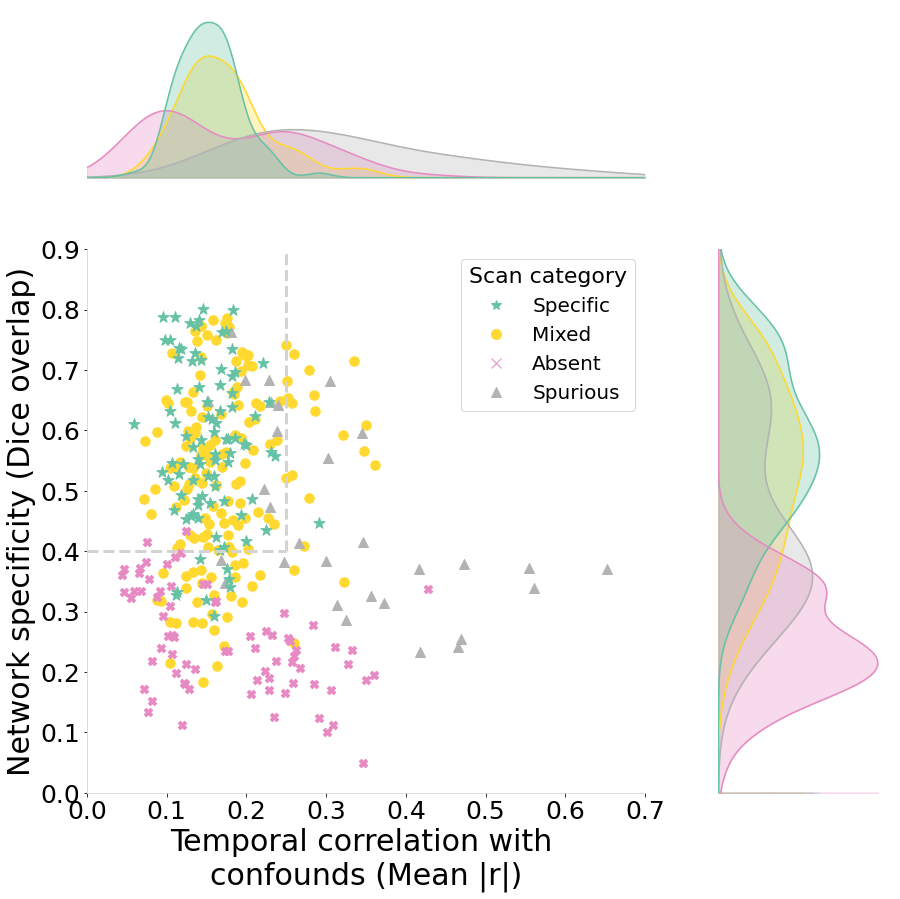

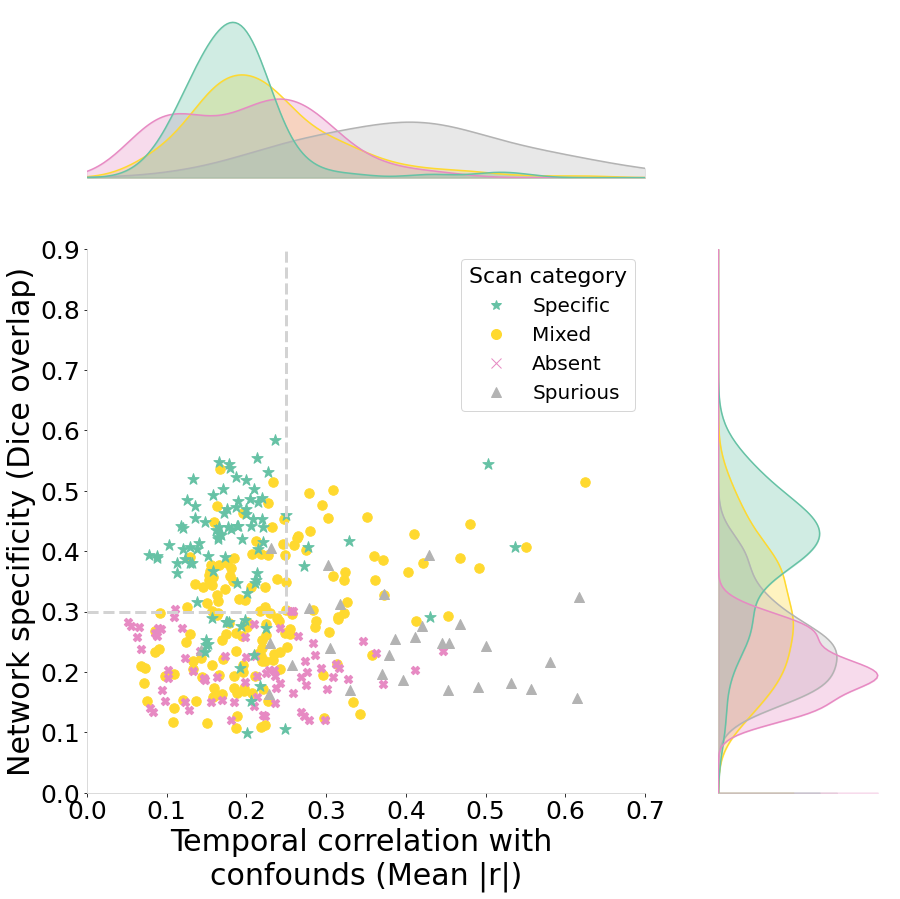

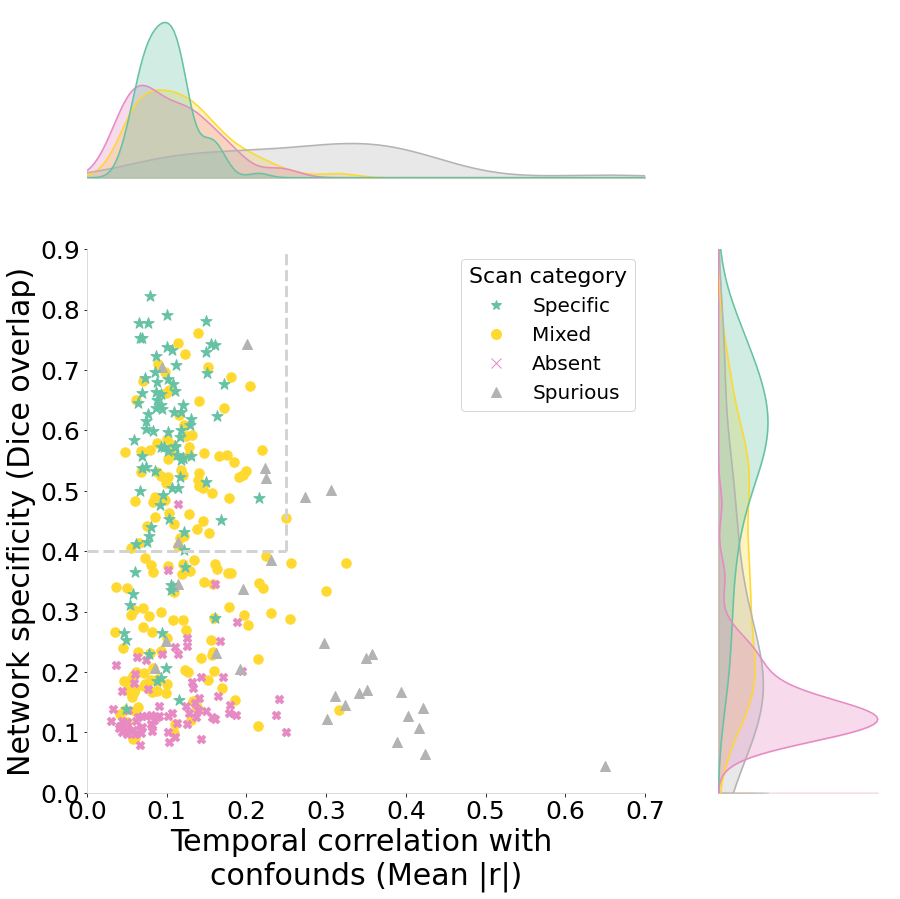

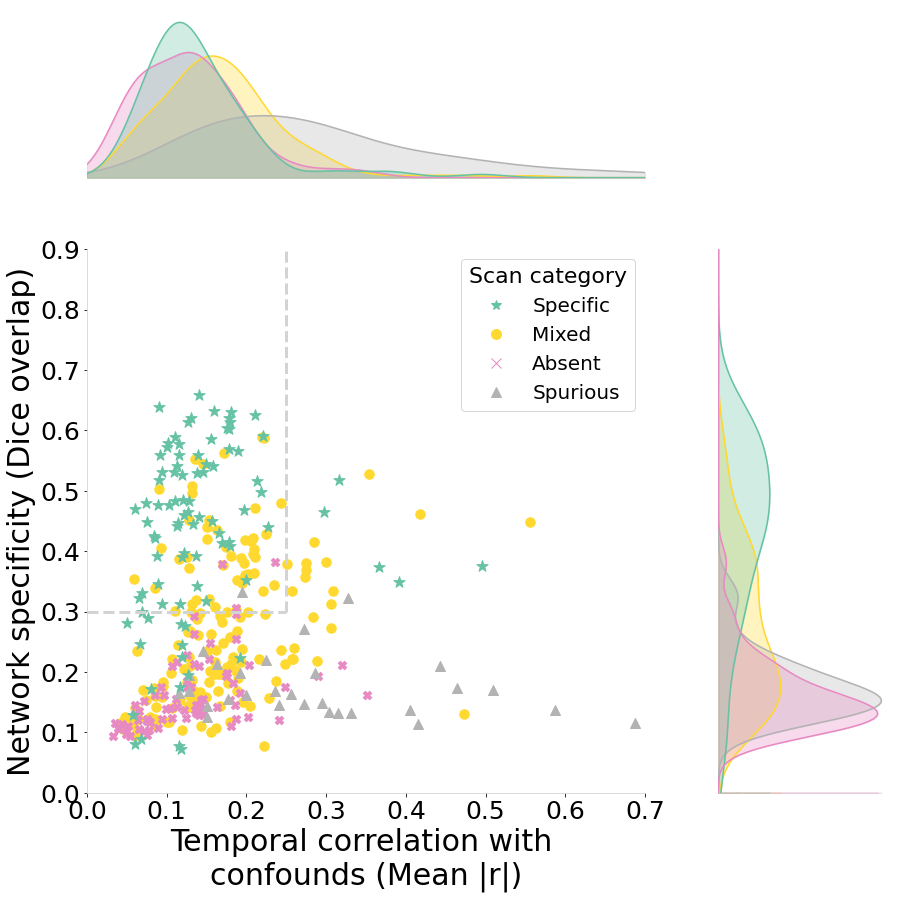

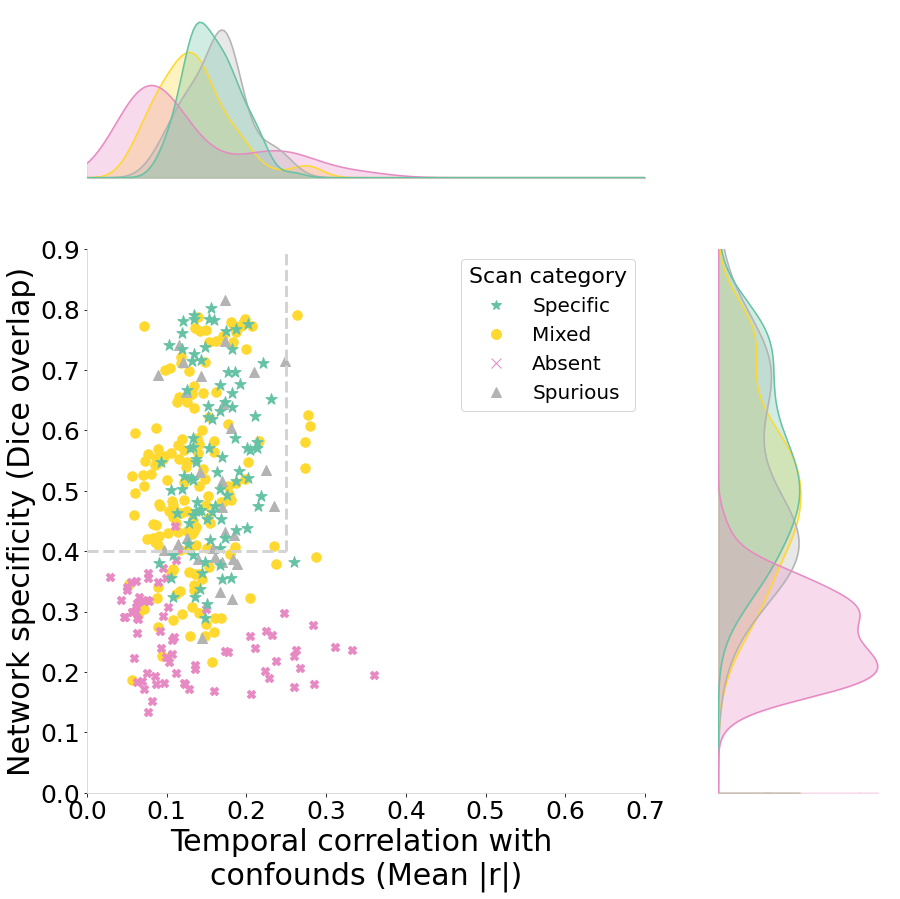

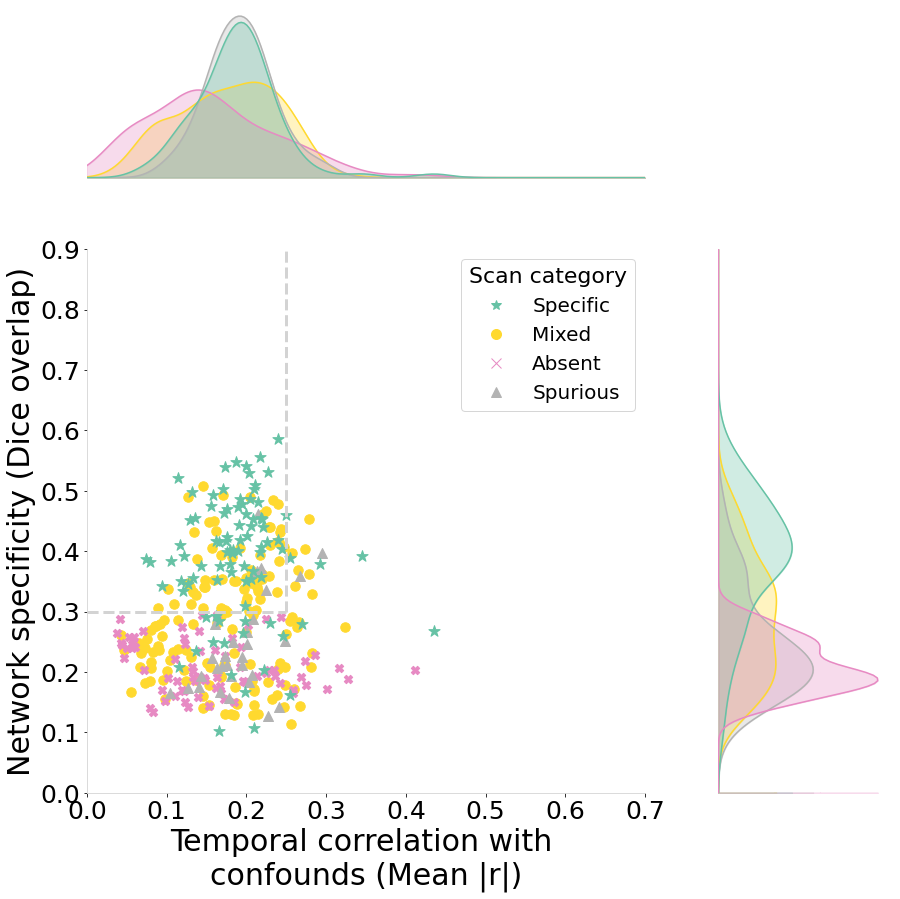

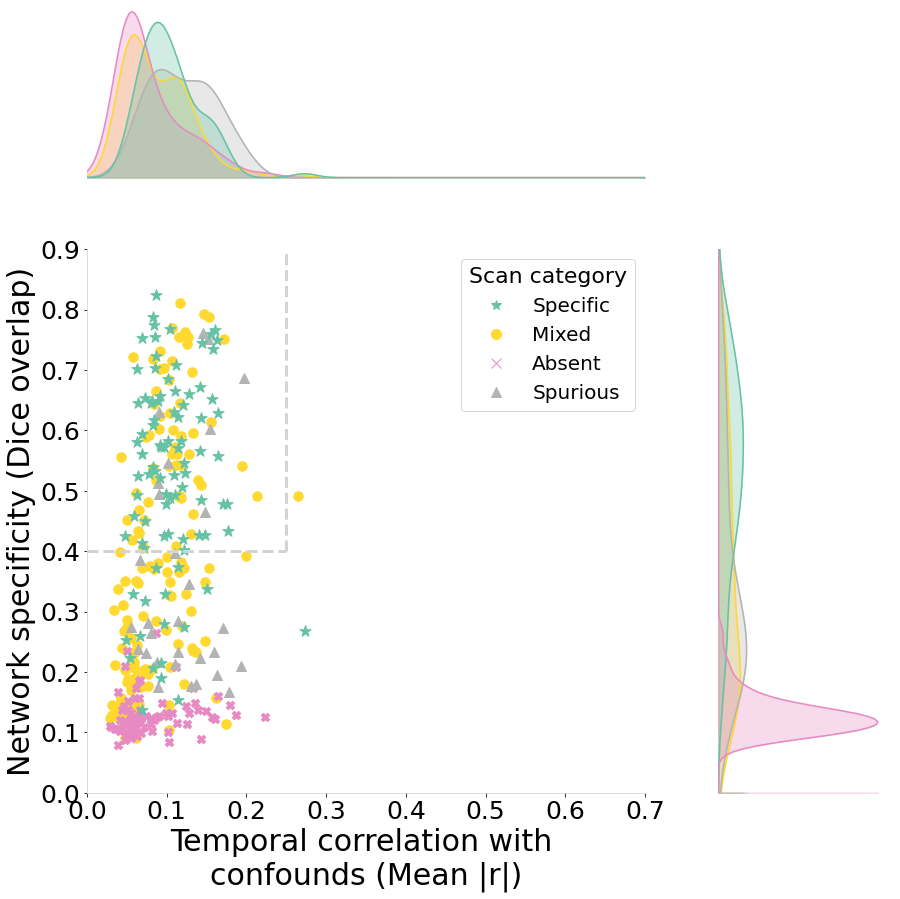

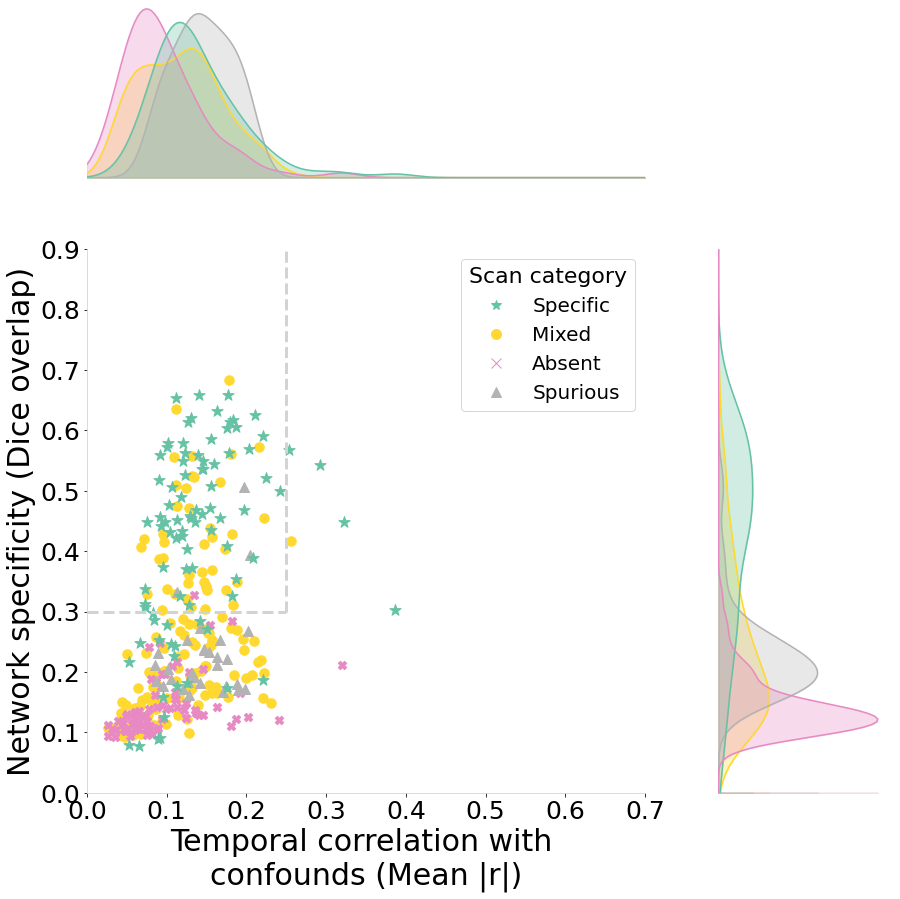

In [5]:
set2_colors = cm.Set2(np.linspace(0, 1, 8))
set2_green = set2_colors[0]
set2_gray = set2_colors[7]
set2_purple = set2_colors[3]
set2_yellow = set2_colors[5]
        
FC_list=['DR0','DR1','seed_FC1','seed_FC0']

for CR_type in ['initial', 'optimized']:
    for FC,dice_threshold in zip(FC_list, [0.4,0.3,0.4,0.3]):

        fig = plt.figure(figsize=(22, 22))
        ax = fig.add_subplot(2,2,3)
        ax_top = fig.add_subplot(6,2,5)
        ax_right = fig.add_subplot(2,6,10)

        ax_top.axis('off')
        ax_right.axis('off')


        y_bounds = [0,0.9]
        x_bounds = [0,0.7]

        ax.set_ylabel('Network specificity (Dice overlap)', fontsize=30)
        ax.set_xlabel("Temporal correlation with \nconfounds (Mean |r|)", fontsize=30)
        ax.set_ylim(y_bounds)
        ax.set_xlim(x_bounds)
        ax2 = ax.twinx()
        ax2.set_ylim(y_bounds)
        ax2.set_xlim(x_bounds)
        ax2.axis('off')

        # QC thresholds
        ax2.plot([0,0.25],[dice_threshold,dice_threshold], color='lightgray', linestyle='--', linewidth=3)
        ax2.plot([0.25,0.25],[dice_threshold,0.9], color='lightgray', linestyle='--', linewidth=3)

        if CR_type=='initial':
            CR='mot6_FD'
        else:
            CR='optimized'

        QC_dict={}
        QC_dict['conf']={}
        QC_dict['dice']={}
        QC_dict['dice']['specific']=[]
        QC_dict['dice']['absent']=[]
        QC_dict['dice']['Mixed']=[]
        QC_dict['dice']['Spurious']=[]
        QC_dict['conf']['specific']=[]
        QC_dict['conf']['absent']=[]
        QC_dict['conf']['Mixed']=[]
        QC_dict['conf']['Spurious']=[]

        for dataset in datasets:

            conf_df_list=[]
            dice_df_list=[]
            for dice,conf in zip(FC_stats[CR][FC][dataset]['Dice'],FC_stats[CR][FC][dataset]['Conf']):
                dice_df_list.append(dice)
                conf_df_list.append(conf)

            if dataset_categories[dataset]=='specific':
                QC_dict['dice']['specific']+=dice_df_list
                QC_dict['conf']['specific']+=conf_df_list
            elif dataset_categories[dataset]=='absent':
                QC_dict['dice']['absent']+=dice_df_list
                QC_dict['conf']['absent']+=conf_df_list
            elif dataset_categories[dataset]=='Mixed':
                QC_dict['dice']['Mixed']+=dice_df_list
                QC_dict['conf']['Mixed']+=conf_df_list
            elif dataset_categories[dataset]=='Spurious':
                QC_dict['dice']['Spurious']+=dice_df_list
                QC_dict['conf']['Spurious']+=conf_df_list


        ax.scatter(QC_dict['conf']['Mixed'],QC_dict['dice']['Mixed'], s=90, color=set2_yellow, marker='o')
        ax.scatter(QC_dict['conf']['absent'],QC_dict['dice']['absent'], s=70, color=set2_purple, marker='X')
        ax.scatter(QC_dict['conf']['Spurious'],QC_dict['dice']['Spurious'], s=100, color=set2_gray, marker='^')
        ax.scatter(QC_dict['conf']['specific'],QC_dict['dice']['specific'], s=140, color=set2_green, marker='*')

        plot_density(v=np.asarray(QC_dict['conf']['Mixed']), bounds=x_bounds, ax=ax_top, color=set2_yellow, axis='x')
        plot_density(v=np.asarray(QC_dict['conf']['absent']), bounds=x_bounds, ax=ax_top, color=set2_purple, axis='x')
        plot_density(v=np.asarray(QC_dict['conf']['Spurious']), bounds=x_bounds, ax=ax_top, color=set2_gray, axis='x')
        plot_density(v=np.asarray(QC_dict['conf']['specific']), bounds=x_bounds, ax=ax_top, color=set2_green, axis='x')

        plot_density(v=np.asarray(QC_dict['dice']['Mixed']), bounds=y_bounds, ax=ax_right, color=set2_yellow, axis='y')
        plot_density(v=np.asarray(QC_dict['dice']['Spurious']), bounds=y_bounds, ax=ax_right, color=set2_gray, axis='y')
        plot_density(v=np.asarray(QC_dict['dice']['specific']), bounds=y_bounds, ax=ax_right, color=set2_green, axis='y')
        plot_density(v=np.asarray(QC_dict['dice']['absent']), bounds=y_bounds, ax=ax_right, color=set2_purple, axis='y')

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)

        import matplotlib.lines as mlines

        green_star = mlines.Line2D([], [], color=set2_green, marker='*', linestyle='None',
                                  markersize=10, label='Specific')
        yellow_circle = mlines.Line2D([], [], color=set2_yellow, marker='o', linestyle='None',
                                  markersize=10, label='Mixed')
        purple_x = mlines.Line2D([], [], color=set2_purple, marker='x', linestyle='None',
                                  markersize=10, label='Absent')
        gray_triangle = mlines.Line2D([], [], color=set2_gray, marker='^', linestyle='None',
                                  markersize=10, label='Spurious')

        leg = ax2.legend(handles=[green_star, yellow_circle, purple_x, gray_triangle], title="Scan category", title_fontsize=22,
                        fontsize=20, loc='upper right')


# group statistic QC

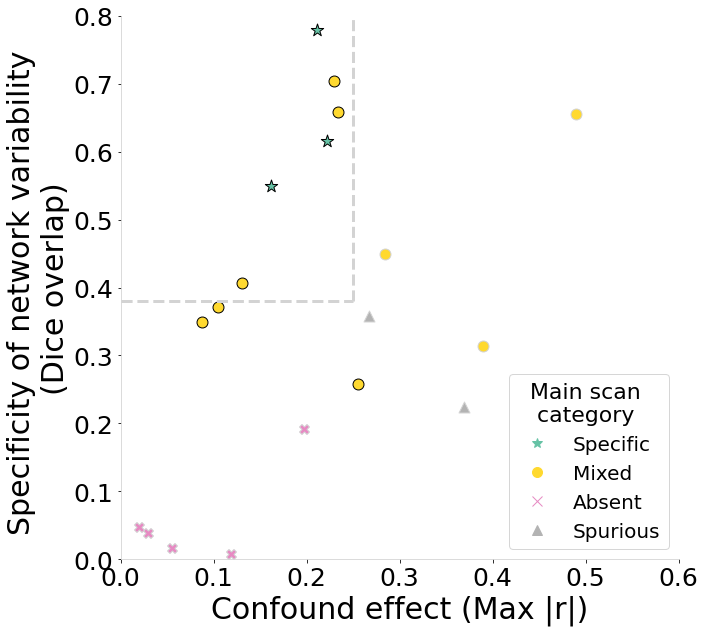

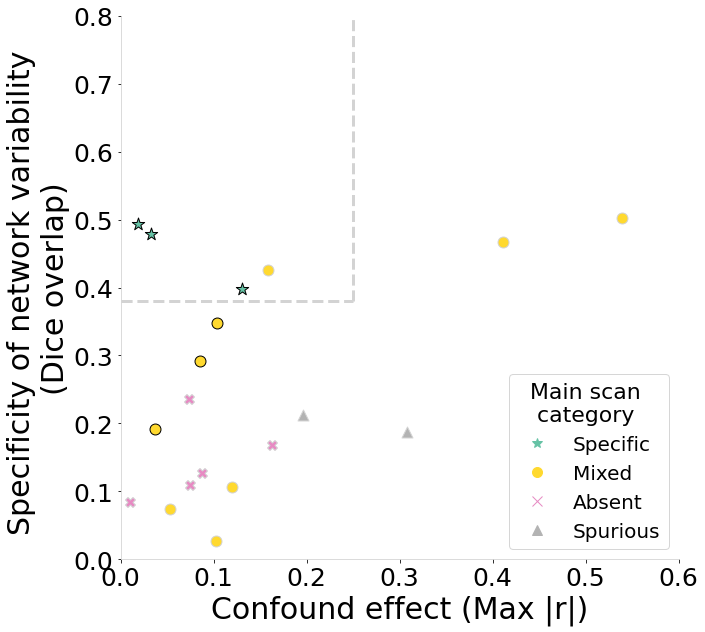

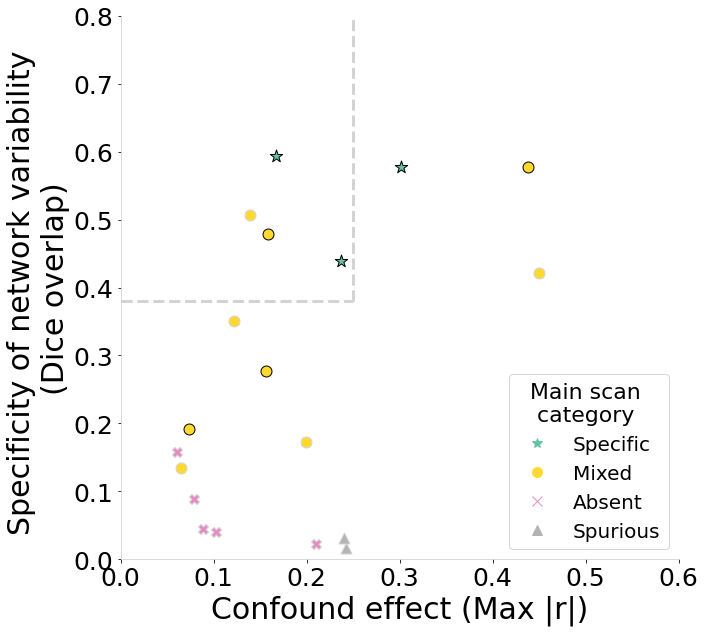

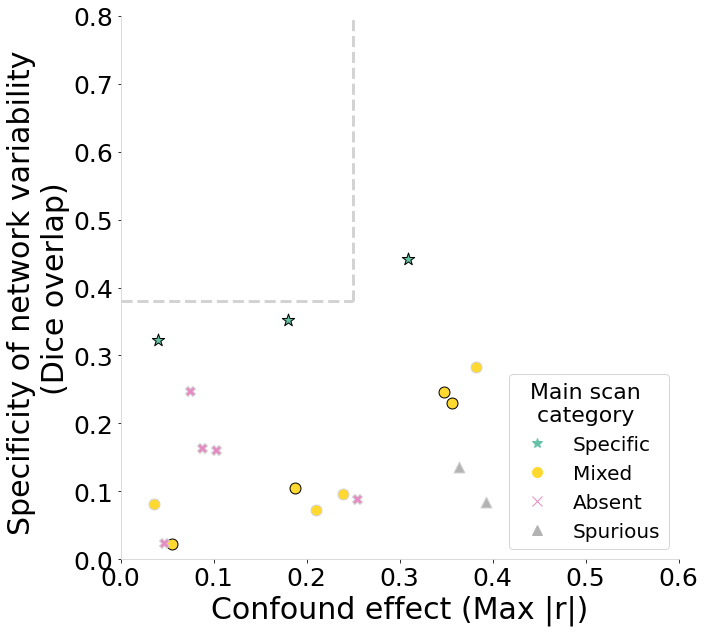

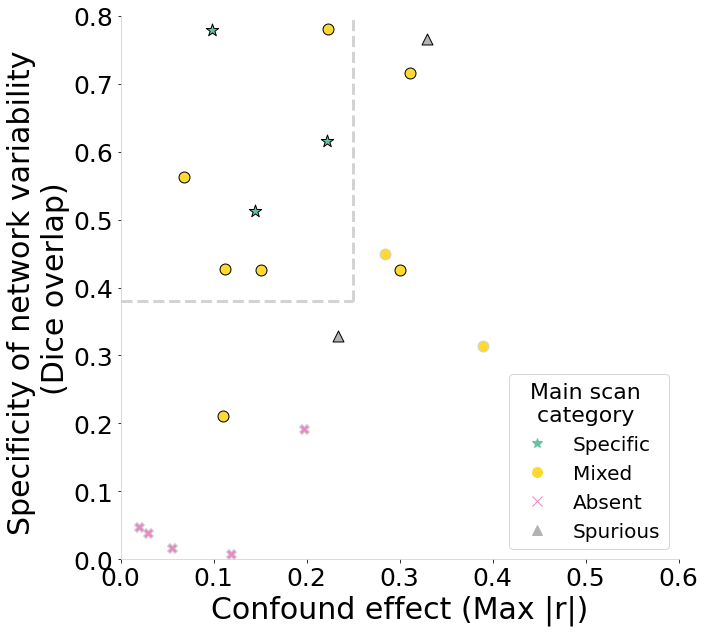

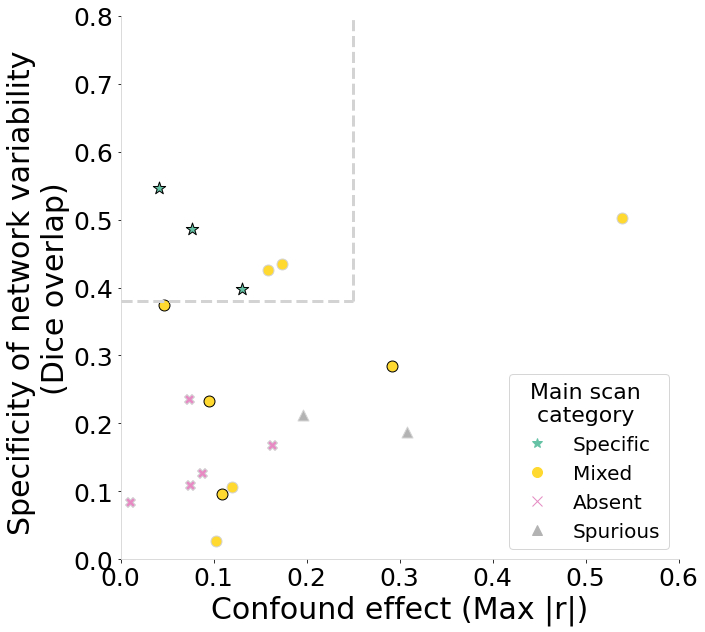

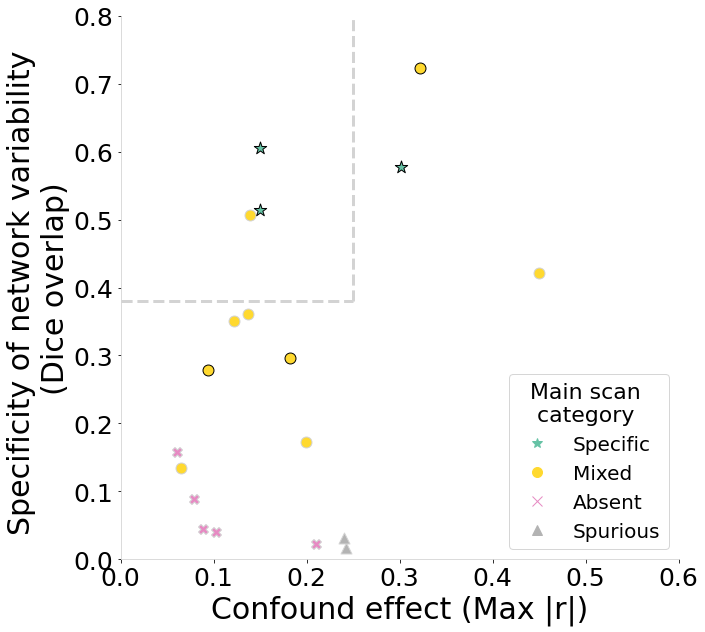

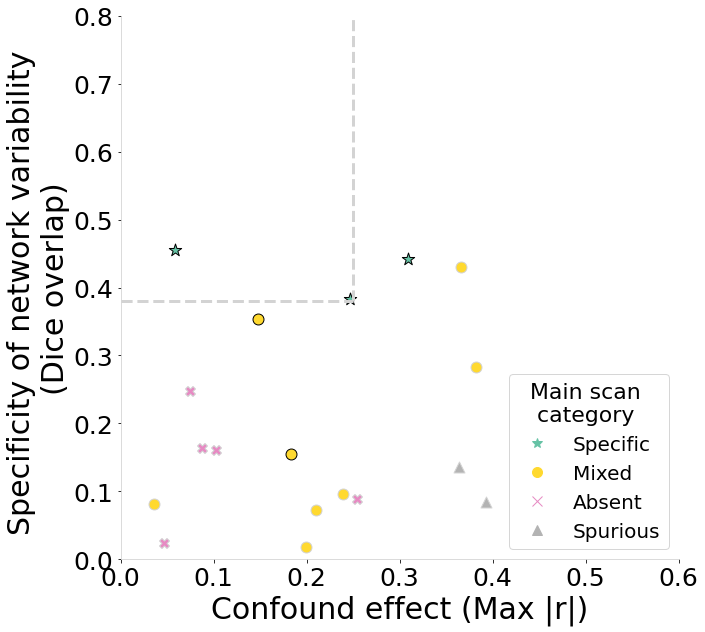

In [6]:
set2_colors = cm.Set2(np.linspace(0, 1, 8))
set2_green = set2_colors[0]
set2_gray = set2_colors[7]
set2_purple = set2_colors[3]
set2_yellow = set2_colors[5]
        
FC_list=['DR0','DR1','seed_FC1','seed_FC0']

for CR_type in ['initial', 'optimized']:
    for FC,dice_threshold in zip(FC_list, [0.4,0.3,0.4,0.3]):

        fig = plt.figure(figsize=(22, 22))
        ax = fig.add_subplot(2,2,3)

        y_bounds = [0,0.8]
        x_bounds = [0,0.6]
        
        ax.set_ylabel('Specificity of network variability \n(Dice overlap)', fontsize=30)
        ax.set_xlabel("Confound effect (Max |r|)", fontsize=30)
        ax.set_ylim(y_bounds)
        ax.set_xlim(x_bounds)
        ax2 = ax.twinx()
        ax2.set_ylim(y_bounds)
        ax2.set_xlim(x_bounds)
        ax2.axis('off')
        
        # QC thresholds
        ax2.plot([0,0.25],[0.38,0.38], color='lightgray', linestyle='--', linewidth=3)
        ax2.plot([0.25,0.25],[0.38,0.8], color='lightgray', linestyle='--', linewidth=3)
                

        for dataset in datasets:
            if CR_type=='initial':
                CR='mot6_FD'
            else:
                CR='optimized'
            if FC_stats[CR][FC][dataset]['num_scans']<8:
                CR='mot6_FD_no_QC'
                edgecolor='lightgray'
            else:
                edgecolor='black'
                
            STD_spec = FC_stats[CR][FC][dataset]['Overlap: Prior - Cross-scan variability']
            FD_effect = np.abs(FC_stats[CR][FC][dataset]['Avg.: Mean FD'])
            CR_effect = np.abs(FC_stats[CR][FC][dataset]['Avg.: CRsd'])
            tDOF_effect = np.abs(FC_stats[CR][FC][dataset]['Avg.: tDOF'])
            max_effect = max(FD_effect,CR_effect,tDOF_effect)

            if dataset_categories[dataset]=='specific':
                color=set2_green
                marker='*'
                s=170
            elif dataset_categories[dataset]=='absent':
                color=set2_purple
                marker='X'
                s=100
            elif dataset_categories[dataset]=='Mixed':
                color=set2_yellow
                marker='o'
                s=120
            elif dataset_categories[dataset]=='Spurious':
                color=set2_gray
                marker='^'
                s=120

                
            ax.scatter(max_effect,STD_spec, s=s, color=color, marker=marker, edgecolor=edgecolor, linewidth=1.0)
                

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)

        import matplotlib.lines as mlines

        green_star = mlines.Line2D([], [], color=set2_green, marker='*', linestyle='None',
                                  markersize=10, label='Specific')
        yellow_circle = mlines.Line2D([], [], color=set2_yellow, marker='o', linestyle='None',
                                  markersize=10, label='Mixed')
        purple_x = mlines.Line2D([], [], color=set2_purple, marker='x', linestyle='None',
                                  markersize=10, label='Absent')
        gray_triangle = mlines.Line2D([], [], color=set2_gray, marker='^', linestyle='None',
                                  markersize=10, label='Spurious')

        leg = ax2.legend(handles=[green_star, yellow_circle, purple_x, gray_triangle], title="Main scan \n category", title_fontsize=22,
                        fontsize=20, loc='lower right')
